In [12]:
from sklearn.base import clone 
from itertools import combinations
from sklearn.metrics import accuracy_score

class Sequential_Backwar_Selection:
    def __init__(self, estimator, k_features, scoring=accuracy_score,                 
                 test_size=0.25, random_state=1):        
 
        self.scoring = scoring        
        self.estimator = clone(estimator)        
        self.k_features = k_features        
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = self.test_size, 
                                                             random_state = self.random_state)
        dim = X_train.shape[1]        
        self.indices_ = tuple(range(dim))        
        self.subsets_ = [self.indices_]        
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)        
        self.scores_ = [score]
        while dim > self.k_features:            
            scores = []            
            subsets = []
            for p in combinations(self.indices_, r=dim - 1):                
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)            
            dim -= 1 
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        return self
    def transform(self, X):        
        return X[:, self.indices_]
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):        
        self.estimator.fit(X_train[:, indices], y_train)        
        y_pred = self.estimator.predict(X_test[:, indices])        
        score = self.scoring(y_test, y_pred)        
        return score    

In [13]:
## Load dataset & split
import numpy as np
from sklearn import neighbors, datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

wine = datasets.load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.3)

# Fit model
knn = neighbors.KNeighborsClassifier(n_neighbors = 6)
sbs = Sequential_Backwar_Selection(knn, k_features = 1)

## Scaling your dataset
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
stdsc.fit(X_train)
X_train_std = stdsc.transform(X_train)
X_test_std = stdsc.transform(X_test)

#Train the model using the training sets
sbs.fit(X_train_std, y_train)

In [14]:
sbs.subsets_

[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12),
 (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12),
 (0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12),
 (0, 1, 2, 3, 4, 5, 6, 7, 9, 12),
 (0, 1, 2, 3, 4, 5, 6, 7, 12),
 (0, 1, 2, 3, 4, 5, 6, 12),
 (0, 1, 2, 3, 4, 6, 12),
 (0, 1, 2, 3, 6, 12),
 (0, 1, 2, 3, 12),
 (0, 1, 2, 12),
 (0, 1, 2),
 (0, 1),
 (0,)]

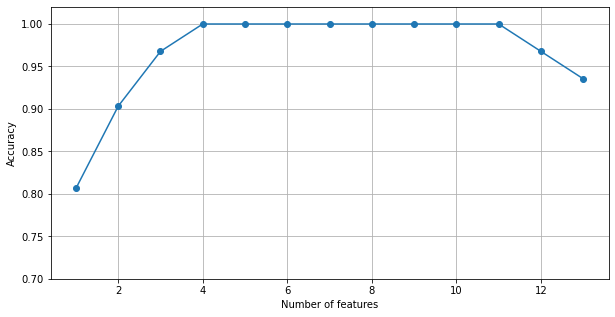

In [15]:
k_feat = [len(k) for k in sbs.subsets_]

plt.figure(figsize = (10, 5))
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02]) 
plt.ylabel('Accuracy') 
plt.xlabel('Number of features')  
plt.grid() 
plt.show()

In [16]:
smax = max(sbs.scores_)
k_best = sbs.scores_.index(smax)
k_best

2

In [17]:
k_4 = list(sbs.subsets_[k_best])
for k in k_4:
    print(wine.feature_names[k])

alcohol
malic_acid
ash
alcalinity_of_ash
magnesium
total_phenols
flavanoids
nonflavanoid_phenols
color_intensity
od280/od315_of_diluted_wines
proline


In [44]:
from sklearn.metrics import classification_report

knn.fit(X_train_std, y_train) 
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))
print(classification_report(knn.predict(X_train_std), y_train))
print(classification_report(knn.predict(X_test_std), y_test))

knn.fit(X_train_std[:, k_4], y_train) 
print('Training accuracy:', knn.score(X_train_std[:, k_4], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k_4], y_test))
print(classification_report(knn.predict(X_train_std[:, k_4]), y_train))
print(classification_report(knn.predict(X_test_std[:, k_4]), y_test))

Training accuracy: 0.967741935483871
Test accuracy: 0.9444444444444444
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        42
           1       0.92      1.00      0.96        48
           2       1.00      0.94      0.97        34

    accuracy                           0.97       124
   macro avg       0.97      0.96      0.97       124
weighted avg       0.97      0.97      0.97       124

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        21
           1       0.84      1.00      0.91        16
           2       1.00      0.94      0.97        17

    accuracy                           0.94        54
   macro avg       0.95      0.95      0.94        54
weighted avg       0.95      0.94      0.95        54

Training accuracy: 0.967741935483871
Test accuracy: 0.9444444444444444
              precision    recall  f1-score   support

           0       1.00      0.95      0.

In [37]:
from sklearn.model_selection import cross_val_score
clf = knn
scores = cross_val_score(clf, wine.data[:, k_4], wine.target, cv=2, scoring = "f1_macro")
scores.mean(), scores.std()

(0.6177784516652323, 0.006719213155013282)

## 2. Using Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=0, max_iter=4000)

sbs = Sequential_Backwar_Selection(logreg, k_features = 1)
sbs.fit(X_train_std, y_train)
k_feat = [len(k) for k in sbs.subsets_]
smax = max(sbs.scores_)
k_best = sbs.scores_.index(smax)
print(k_best)
k_4 = list(sbs.subsets_[k_best])
for k in k_4:
    print(wine.feature_names[k])
    
logreg.fit(X_train_std, y_train) 
print("Using full-features")
print('Training accuracy:', logreg.score(X_train_std, y_train))
print('Test accuracy:', logreg.score(X_test_std, y_test))
print(classification_report(logreg.predict(X_train_std), y_train))
print(classification_report(logreg.predict(X_test_std), y_test))

print("Using full-features")
knn.fit(X_train_std[:, k_4], y_train) 
print('Training accuracy:', logreg.score(X_train_std[:, k_4], y_train))
print('Test accuracy:', logreg.score(X_test_std[:, k_4], y_test))
print(classification_report(logreg.predict(X_train_std[:, k_4]), y_train))
print(classification_report(logreg.predict(X_test_std[:, k_4]), y_test))

0
alcohol
malic_acid
ash
alcalinity_of_ash
magnesium
total_phenols
flavanoids
nonflavanoid_phenols
proanthocyanins
color_intensity
hue
od280/od315_of_diluted_wines
proline
Using full-features
Training accuracy: 1.0
Test accuracy: 0.9814814814814815
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        52
           2       1.00      1.00      1.00        32

    accuracy                           1.00       124
   macro avg       1.00      1.00      1.00       124
weighted avg       1.00      1.00      1.00       124

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.95      1.00      0.97        18
           2       1.00      0.94      0.97        17

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98 

### 2.2. KFold and Logistic-Regression

In [46]:
import time
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, max_iter=4000)
%time scores = cross_val_score(clf, wine.data[:, k_4], wine.target, cv=20, scoring = "f1_macro")
scores.mean(), scores.std()

CPU times: user 17 s, sys: 1.9 ms, total: 17 s
Wall time: 17.1 s


(0.9670767195767196, 0.06433405954244736)

#### display

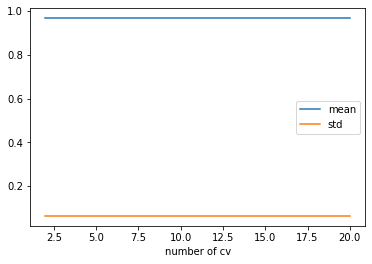

In [52]:
means = []
stds = []
for cv in range(2, 21):
    scores = cross_val_score(clf, wine.data[:, k_4], wine.target, cv=20, scoring = "f1_macro")
    means.append(scores.mean())
    stds.append(scores.std())

plt.plot(range(2, 21), means, label = 'mean')
plt.plot(range(2, 21), stds, label = 'std')
plt.xlabel("number of cv")
plt.legend()
plt.show()

## 3. Using RandomForest

In [54]:
from sklearn.ensemble import RandomForestClassifier
feat_labels = wine.feature_names  ## df_wine.columns[1:]
rf = RandomForestClassifier(n_estimators = 500, random_state = 1)
rf.fit(X_train_std, y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]): 
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) color_intensity                0.177167
 2) proline                        0.175706
 3) od280/od315_of_diluted_wines   0.133576
 4) flavanoids                     0.124373
 5) alcohol                        0.108575
 6) hue                            0.074904
 7) total_phenols                  0.051912
 8) magnesium                      0.039559
 9) alcalinity_of_ash              0.035302
10) malic_acid                     0.032380
11) proanthocyanins                0.027159
12) ash                            0.013578
13) nonflavanoid_phenols           0.005809


In [64]:
rf = RandomForestClassifier(n_estimators = 500, random_state = 1)
%time scores = cross_val_score(rf, wine.data[:, indices[:7]], wine.target, cv=20, scoring = "f1_macro")
scores.mean(), scores.std()

CPU times: user 19.5 s, sys: 125 ms, total: 19.6 s
Wall time: 19.6 s


(0.972910052910053, 0.047080315286280275)